In [1]:
import sys
sys.path.append('../utils')
sys.path.append('../core')
sys.path.append('../')
import numpy as np
import scipy
import tqdm
import utils
import geometry
from core import *

import matplotlib.pyplot as plt
import plotly.graph_objects as go
import glob

In [2]:
test_phantom = phantom.Phantom.load('../experiment_files/cardiac_phantom')

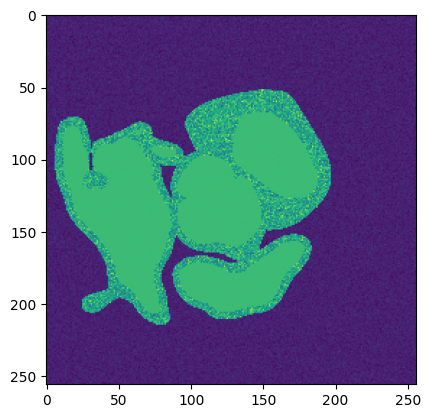

In [3]:
plt.imshow(test_phantom.get_complete()[0,:,:,test_phantom.matrix_dims[2]//2])

In [4]:
transducers = [transducer.Focused(max_frequency = 2e6,
                                  elements = 64, 
                                  width = 30e-3,
                                  height =  30e-3,
                                  sensor_sampling_scheme = 'not_centroid', 
                                  sweep = np.pi/3,
                                  ray_num = 32, 
                                  imaging_ndims = 2,
                                  focus_azimuth = 100e-3,
                                  focus_elevation = 100e-3,
) for i in range(1)]

for t in transducers:
    t.make_sensor_coords(test_phantom.baseline[0])

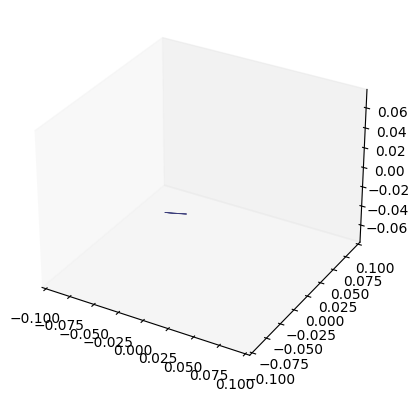

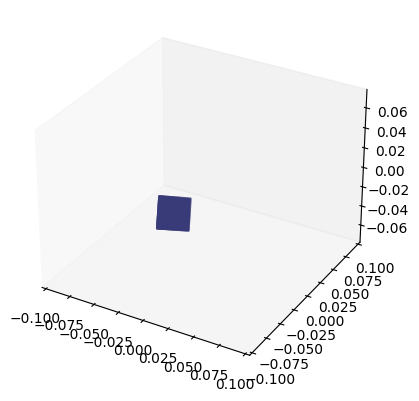

In [5]:
test_transducer_set = transducer_set.TransducerSet(transducers, seed=8888)
test_transducer_set.assign_pose(0, geometry.Transform([-np.pi*0.28,-np.pi*0.18,-np.pi*0.05], [-.055,0.04,-0.062]))
# test_transducer_set.assign_pose(0, geometry.Transform([-np.pi*0.3,-np.pi*0.15,-np.pi*0.05], [-.06,0.06,-0.065]))

# test_transducer_set.assign_pose(0, geometry.Transform([-np.pi*3/20,np.pi/6,0], [-0.07,0.03,0.05]))
test_transducer_set.plot_transducer_fovs(scale=0.1)
test_transducer_set.plot_transducer_coords(scale=0.1)

In [6]:
# test_sensor = sensor.Sensor(transducer_set=test_transducer_set, aperture_type='pressure_field')
test_sensor = sensor.Sensor(transducer_set=test_transducer_set, aperture_type='transmit_as_receive')

In [7]:
simprops = simulation.SimProperties(
                grid_size   = (140e-3,50e-3,50e-3),
                voxel_size  = (0.1e-3,0.1e-3,0.1e-3),
                PML_size    = (32,8,8),
                PML_alpha   = 2,
                t_end       = 12e-5,           # [s]
                bona        = 6,               # parameter b/a determining degree of nonlinear acoustic effects
                alpha_coeff = 0.5, 	           # [dB/(MHz^y cm)]
                alpha_power = 1.5,
                )

In [8]:
test_experiment = experiment.Experiment(
                 simulation_path = '../experiment_files/cardiac_experiment',
                 sim_properties  = simprops,
                 phantom         = test_phantom,
                 transducer_set  = test_transducer_set,
                 sensor          = test_sensor,
                 nodes           = 1,
                 results         = None,
                 indices         = None,
                 workers         = 3,
                 additional_keys = []
                 )

test_experiment.save()

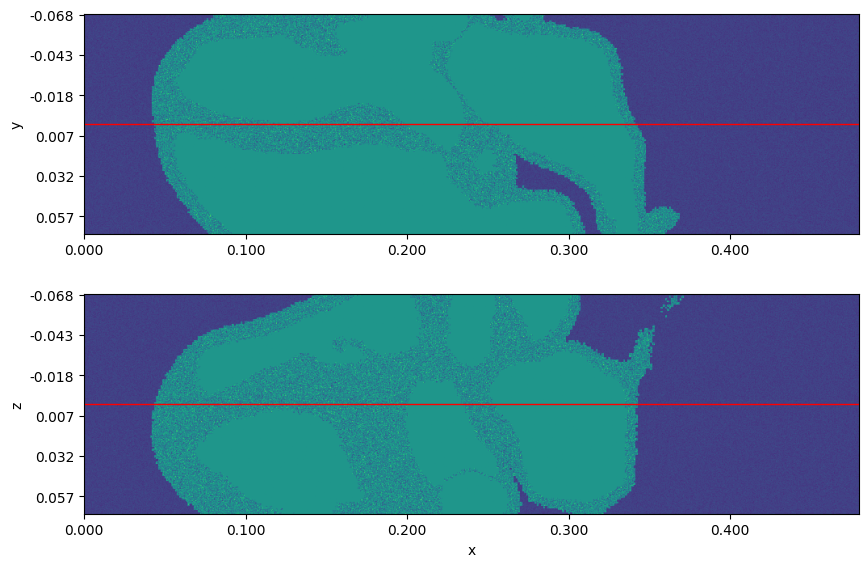

In [9]:
test_experiment.plot_ray_path(15)

In [10]:
test_experiment = experiment.Experiment.load('../experiment_files/cardiac_experiment')
test_experiment.run(dry=True)

dry run of simulation


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.43s/it]


In [11]:
test_experiment.run(repeat=True)

running with 3 workers

preparation for sim   16 completed in           33.74 seconds

preparation for sim    0 completed in           36.03 seconds

preparation for sim   17 completed in           50.68 seconds

preparation for sim    1 completed in           56.87 seconds

preparation for sim   18 completed in          136.72 seconds

preparation for sim    2 completed in          129.84 seconds



┌───────────────────────────────────────────────────────────────┐
│                  kspaceFirstOrder-CUDA v1.3                   │
├───────────────────────────────────────────────────────────────┤
│ Reading simulation configuration:                        Done │
│ Selected GPU device id:                                     0 │
│ GPU device name:               NVIDIA RTX 6000 Ada Generation │
│ Number of CPU threads:                                     32 │
│ Processor name: AMD Ryzen Threadripper PRO 5955WX 16-Cores    │
├───────────────────────────────────────────────────────────────┤
│                      Simulation details                       │
├───────────────────────────────────────────────────────────────┤
│ Domain dimensions:                           1024 x 288 x 288 │
│ Medium type:                                               3D │
│ Simulation time steps:                                   5334 │
├───────────────────────────────────────────────────────────────┤
│         

In [ ]:
test_experiment.add_results()

In [ ]:
test_reconstruction = reconstruction.DAS(experiment=test_experiment)

In [ ]:
# test_reconstruction.plot_ray_path(0)

In [ ]:
# test_reconstruction.plot_scatter()

In [ ]:
image, signals = test_reconstruction.get_image(dimensions=2, downsample = 1, workers=1)

multiproc time 0.11865234375


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.64s/it]


[]

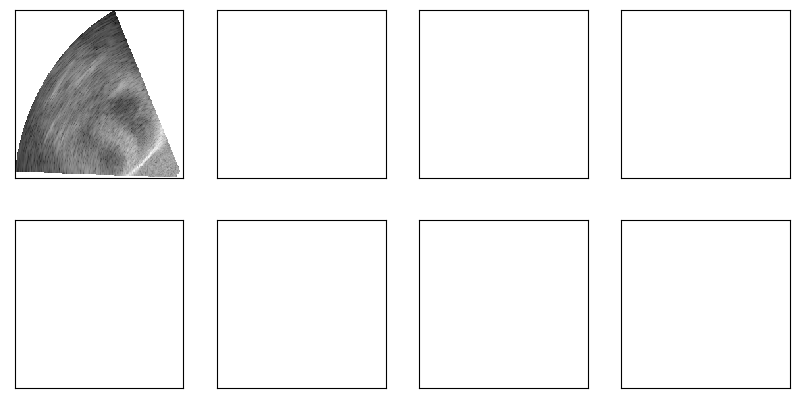

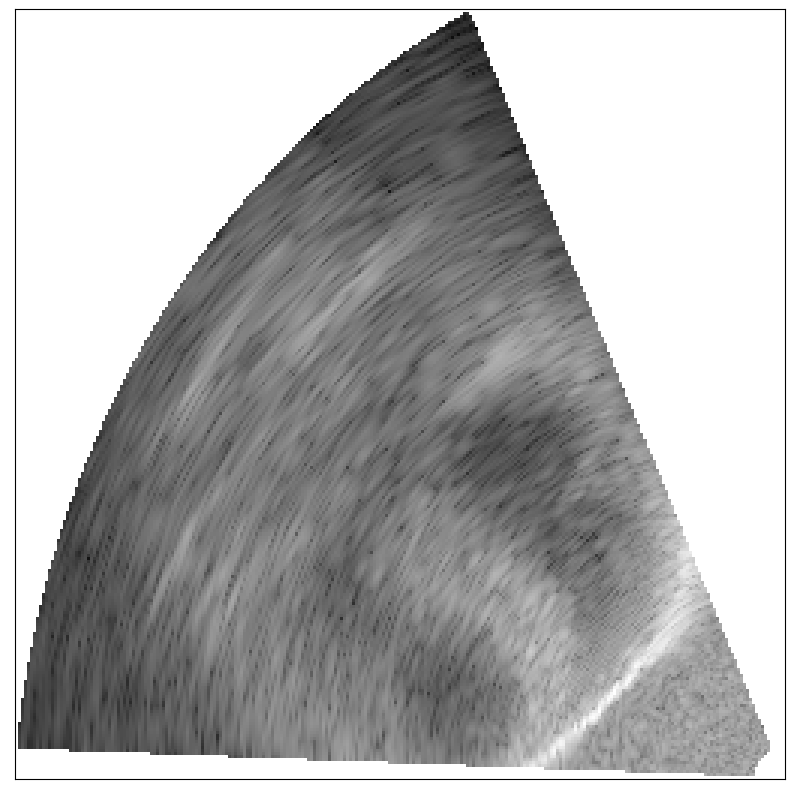

In [ ]:
X = np.linspace(-1, 1, 256)
Y = np.linspace(-1, 1, 256)
X, Y = np.meshgrid(X, Y)

fig, ax = plt.subplots(2,4, figsize=(10,5))
ax[0,0].pcolormesh(X, Y, signals[0], shading='auto', cmap='gray', norm='log')
# ax[0,1].pcolormesh(X, Y, signals[1], shading='auto', cmap='gray', norm='log')
# ax[0,2].pcolormesh(X, Y, signals[2], shading='auto', cmap='gray', norm='log')
# ax[0,3].pcolormesh(X, Y, signals[3], shading='auto', cmap='gray', norm='log')
# ax[1,0].pcolormesh(X, Y, signals[4], shading='auto', cmap='gray', norm='log')
# ax[1,1].pcolormesh(X, Y, signals[5], shading='auto', cmap='gray', norm='log')
# ax[1,2].pcolormesh(X, Y, signals[6], shading='auto', cmap='gray', norm='log')
# ax[1,3].pcolormesh(X, Y, signals[7], shading='auto', cmap='gray', norm='log')

for axd1 in ax:
    for a in axd1:
        a.set_aspect('equal')
        a.set_xticks([])
        a.set_yticks([])

fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.pcolormesh(X, Y, image, shading='auto', cmap='gray', norm='log')
ax.set_aspect('equal')
ax.set_xticks([])
ax.set_yticks([])

/tmp/ipykernel_551408/4135272851.py:3: RuntimeWarning: invalid value encountered in log
  ax.pcolor(np.log(image_rays + 2))


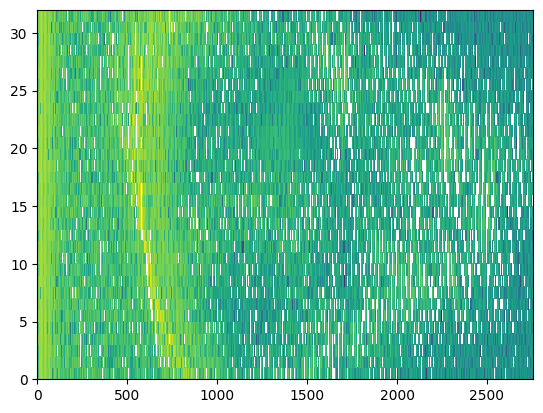

In [ ]:
fig, ax = plt.subplots(1, 1)
image_rays = np.stack([np.mean(test_experiment.results[i][1], axis=0)[100:] for i in range(len(test_experiment.results))])
ax.pcolor(np.log(image_rays + 2))

In [ ]:
im = test_reconstruction.results[0][2]

In [ ]:
im2 = im.reshape((1232,112,-1))

ValueError: cannot reshape array of size 1925 into shape (1232,112,newaxis)

In [ ]:
plt.imshow(im2)

In [ ]:
im.shape

In [ ]:
plt.imshow(im[:,:,300].T, cmap='bwr')

In [ ]:
for frame in tqdm.tqdm(range(0,im.shape[-1],10)):
    plt.imshow(im[:,:,frame], cmap='bwr')
    plt.colorbar()
    plt.savefig(f'../experiment_files/outputs/frame_{str(frame).zfill(4)}.png', dpi=50)
    plt.close()